# Klasyfikacja raka mózgu - Hubert Jaremko

## Modele klasyczne

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import walk
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import History
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.utils import np_utils

### Ustawienia

In [4]:
cancer_type = {0 : 'Oponiak', 1 : 'Glejak', 2 : 'Guz przysadki'}

In [5]:
# image_size = (512, 512)
# image_size = (224, 224)
# image_size = (128, 128)
image_size = (64, 64)
# image_size = (32, 32)
batch_size = 32

train_dir = "data/train"
val_dir = "data/val"

## Funkcje pomocnicze

In [6]:
def generator_to_array(data_generator):
    data_list = []
    batch_index = 0

    while batch_index <= data_generator.batch_index:
        data = data_generator.next()
        data_list.append(data[0])
        batch_index = batch_index + 1

    data_array = np.asarray(data_list, dtype=object)
    X = np.concatenate(data_array, axis=0)
    y = data_generator.classes
    y = np_utils.to_categorical(y)
    return (X, y)

In [7]:
def plot_metrics(history):
    metrics = ['loss', 'categorical_accuracy', 'precision', 'recall']
    plt.figure(figsize=(12, 7))
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n + 1)
        plt.plot(history.epoch, history.history[metric], label='Train')
        plt.plot(history.epoch, history.history['val_' + metric], linestyle="--", label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.ylim([0, 1])
        plt.legend()

In [8]:
def plot_confusion_matrix(y_pred, y_true, ax):
    cm = metrics.confusion_matrix(y_pred=predicted_classes, y_true=true_classes)
    sn.heatmap(cm, annot=True, fmt='g', cmap="RdPu", ax=ax)

In [9]:
target = ['Oponiak', 'Glejak', 'Guz przysadki']

def binarize_labels(y_test):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    return y_test

def multiclass_roc_auc_score(y_test, y_pred, c_ax, average="macro"):
    y_test = binarize_labels(y_test)
#     y_pred = binarize_labels(y_pred)

    for (idx, c_label) in enumerate(target):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = f'{c_label} (AUC:{auc(fpr, tpr):0.2f})')

    c_ax.plot(fpr, fpr, '--', color = '0.75', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

def plot_roc_curve(y_test, y_pred, c_ax):
    print('ROC AUC score:', multiclass_roc_auc_score(y_test, y_pred, c_ax))

    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

## Wczytanie zbioru treningowego i testowego

In [10]:
from os import walk
from PIL import Image

def read_brains(data, source, filenames, t):
    for filename in filenames:
        image = Image.open(f'data/{source}/{t}/{filename}').convert('L')
        img = np.array(image)
        data.append((img, t))

In [11]:
def read_brain_dir(directory):
    brains_data = []

    _, _, type_1_filenames = next(walk(f'data/{directory}/1/'))
    _, _, type_2_filenames = next(walk(f'data/{directory}/2/'))
    _, _, type_3_filenames = next(walk(f'data/{directory}/3/'))
    read_brains(brains_data, directory, type_1_filenames, 1)
    read_brains(brains_data, directory, type_2_filenames, 2)
    read_brains(brains_data, directory, type_3_filenames, 3)
    
    return brains_data

In [12]:
def raw_brain_data_to_dataframe(directory):
    raw = read_brain_dir(directory)
    return pd.DataFrame(data=raw, columns=['image', 'tumor_class'])

In [13]:
train_df = raw_brain_data_to_dataframe('train')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        480 non-null    object
 1   tumor_class  480 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 7.6+ KB


In [14]:
test_df = raw_brain_data_to_dataframe('val')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        120 non-null    object
 1   tumor_class  120 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.0+ KB


### Dodanie etykiet

In [15]:
from sklearn.preprocessing import LabelEncoder

def encode_labels(df):
    X = df.drop(['tumor_class'], axis=1)
    y = df['tumor_class'].values

    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)

    print("X.shape: {} y.shape: {}".format(X.shape, y.shape))
    return (X, y)

In [16]:
X_train, y_train = encode_labels(train_df)

X.shape: (480, 1) y.shape: (480,)


In [17]:
X_test, y_test = encode_labels(test_df)

X.shape: (120, 1) y.shape: (120,)


### Skalowanie

In [18]:
from sklearn.base import BaseEstimator, TransformerMixin

from skimage.transform import resize

class Flattener(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        arr = np.array([resize(x, image_size) for x in X['image'].values])
        return arr.reshape((-1, image_size[0] * image_size[1]))
    
class Normalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X / 255.

In [19]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("flatten_image", Flattener()),
    ])

### Próbka zbioru treningowego

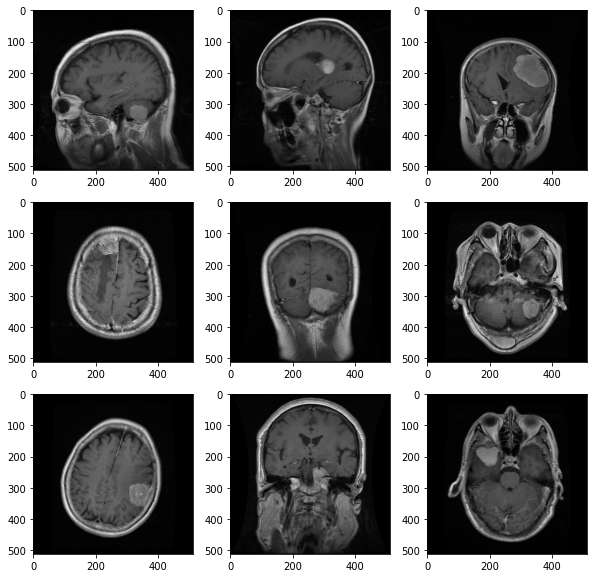

In [20]:
plt.figure(figsize=(10, 10))

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    image = X_train['image'][i]
    plt.imshow(image.astype("uint8"), cmap='gray')

## Modele

In [21]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from scipy.stats.distributions import uniform, randint
from sklearn.linear_model import LogisticRegression

In [22]:
seed=123
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

In [23]:
models = {}

In [24]:
def fit_grid(grid, name, X_train, y_train):
    grid.fit(X_train, y_train)
    models[name] = grid.best_estimator_
    print(grid.best_params_)

### 1. SVM linear

In [25]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', SVC(kernel='linear', probability=True, verbose=True))])

param_grid = {
            'classifier__C': [0.01, 0.1, 1]
}

grid_svm_linear = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise', n_jobs=-1, verbose=2)

In [26]:
fit_grid(grid_svm_linear, 'svm_linear', X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[LibSVM]{'classifier__C': 0.1}


### 2. SVC rbf

In [27]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', SVC(kernel='rbf', probability=True, verbose=True))])

param_grid = {
            'classifier__C': [0.01, 0.1, 1]
}

grid_svm_rbf = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise', n_jobs=-1, verbose=2)

In [28]:
fit_grid(grid_svm_rbf, 'svm_rbf', X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[LibSVM]{'classifier__C': 1}


### 3. SVM poly

In [29]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', SVC(kernel='poly', probability=True, verbose=True))])

param_grid = {
            'classifier__C': [0.1, 1, 10],
            'classifier__degree': [1, 2, 3, 4],
            'classifier__coef0': [0.01, 0.1, 1],
}

grid_svm_poly = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise', n_jobs=-1, verbose=2)

In [30]:
fit_grid(grid_svm_poly, 'svm_poly', X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[LibSVM]{'classifier__C': 1, 'classifier__coef0': 1, 'classifier__degree': 3}


### 4. SVM sigmoid

In [31]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', SVC(kernel='poly', probability=True, verbose=True))])

param_grid = {
            'classifier__C': [0.1, 1, 10],
            'classifier__coef0': [0.1, 1, 10],
}

grid_svm_sigmoid = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise', n_jobs=-1, verbose=2)

In [32]:
fit_grid(grid_svm_sigmoid, 'svm_sigmoid', X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[LibSVM]{'classifier__C': 1, 'classifier__coef0': 1}


### 5. LogisticRegression

In [33]:
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', LogisticRegression(verbose=True))
])

param_grid = {
            'classifier__C': [0.1, 1, 10],
}

grid_log_reg = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise', n_jobs=-1, verbose=2)

In [34]:
fit_grid(grid_log_reg, 'log_reg', X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'classifier__C': 1}


C:\Users\Hubert\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


### 6. KNeighborsClassifier

In [37]:
from sklearn.neighbors import KNeighborsClassifier
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', KNeighborsClassifier())
])

param_grid = {
            'classifier__p': [1, 5, 10],
}

grid_kneighbors = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise', n_jobs=-1, verbose=2)

In [38]:
fit_grid(grid_kneighbors, 'kneighbors', X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'classifier__p': 1}


### 7. DecisionTreeClassifier

In [39]:
from sklearn.tree import DecisionTreeClassifier

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', DecisionTreeClassifier())
])

param_grid = {
            'classifier__max_depth': [5, 10, 20],
            'classifier__max_leaf_nodes': [None, 5, 10],
}

grid_decisiontree = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise', n_jobs=-1, verbose=2)

In [40]:
fit_grid(grid_decisiontree, 'Decision Tree', X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'classifier__max_depth': 20, 'classifier__max_leaf_nodes': 10}


### 8. RandomForestClassifier

In [41]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', RandomForestClassifier(verbose=True, n_jobs=4))
])

param_grid = {
            'classifier__n_estimators' : [50, 70],
            'classifier__max_leaf_nodes' : [64, 128, 256],
}

grid_randomforest = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise', n_jobs=-1, verbose=2)

In [42]:
fit_grid(grid_randomforest, 'Random Forest', X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


{'classifier__max_leaf_nodes': 64, 'classifier__n_estimators': 50}


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.3s finished


### 9. BaggingClassifier

In [43]:
from sklearn.ensemble import BaggingClassifier

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', BaggingClassifier(verbose=True, n_jobs=4))
])

param_grid = {
            'classifier__max_samples' : [0.1, 0.5, 1]
}

grid_bagging = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise', n_jobs=-1, verbose=2)

In [44]:
fit_grid(grid_bagging, 'Bagging', X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.8s remaining:    0.8s


{'classifier__max_samples': 0.5}


[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    1.0s finished


### 10. ExtraTreesClassifier

In [45]:
from sklearn.ensemble import ExtraTreesClassifier

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', ExtraTreesClassifier(verbose=True, n_jobs=4))
])

param_grid = {
            'classifier__n_estimators' : [10, 25, 50],
            'classifier__max_leaf_nodes' : [32, 64, 128],
}

grid_extratrees = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise', n_jobs=-1, verbose=2)

In [46]:
fit_grid(grid_extratrees, 'Extra Trees', X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'classifier__max_leaf_nodes': 128, 'classifier__n_estimators': 50}


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


### 11. AdaBoostClassifier

In [47]:
from sklearn.ensemble import AdaBoostClassifier

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', AdaBoostClassifier())
])

param_grid = {
            'classifier__n_estimators' : [10, 50, 100],
            'classifier__learning_rate' : [0.01, 0.1],
}

grid_adaboost = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise', n_jobs=-1, verbose=2)

In [48]:
fit_grid(grid_adaboost, 'AdaBoost', X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 50}


### 12. GradientBoostingClassifier

In [49]:
from sklearn.ensemble import GradientBoostingClassifier

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', GradientBoostingClassifier(verbose=True))
])

param_grid = {
            'classifier__n_estimators' : [25, 50, 75],
            'classifier__learning_rate' : [0.05, 0.1],
}

grid_gradientbost = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise', n_jobs=-1, verbose=2)

In [50]:
fit_grid(grid_gradientbost, 'Gradient Boosting', X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
      Iter       Train Loss   Remaining Time 
         1           0.9646            1.27m
         2           0.8588            1.27m
         3           0.7680            1.25m
         4           0.6939            1.23m
         5           0.6270            1.21m
         6           0.5734            1.20m
         7           0.5272            1.18m
         8           0.4890            1.17m
         9           0.4510            1.15m
        10           0.4156            1.13m
        20           0.2062           57.20s
        30           0.1256           46.97s
        40           0.0810           36.57s
        50           0.0557           26.15s
        60           0.0387           15.72s
        70           0.0276            5.25s
{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 75}


### 13. MLPClassifier

In [51]:
from sklearn.neural_network import MLPClassifier

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('classifier', MLPClassifier(verbose=True))
])

param_grid = {
            'classifier__hidden_layer_sizes': [(200, 100, 50, 10), (300, 150)],
            'classifier__learning_rate_init': [0.01, 0.1],
            'classifier__max_iter': [300],
            'classifier__batch_size': [32],
            'classifier__activation': ['relu'],
}

grid_mlp = GridSearchCV(pipe, param_grid, cv=kfold, error_score='raise', n_jobs=-1, verbose=2)

In [52]:
fit_grid(grid_mlp, 'MLP Classifier', X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Iteration 1, loss = 4.61016932
Iteration 2, loss = 0.83648100
Iteration 3, loss = 0.64204194
Iteration 4, loss = 0.61517203
Iteration 5, loss = 0.54227996
Iteration 6, loss = 0.54603177
Iteration 7, loss = 0.46072209
Iteration 8, loss = 0.38783665
Iteration 9, loss = 0.33516866
Iteration 10, loss = 0.30773988
Iteration 11, loss = 0.22935099
Iteration 12, loss = 0.22552053
Iteration 13, loss = 0.19987468
Iteration 14, loss = 0.21984993
Iteration 15, loss = 0.16493219
Iteration 16, loss = 0.14641458
Iteration 17, loss = 0.16585852
Iteration 18, loss = 0.20334714
Iteration 19, loss = 0.17990196
Iteration 20, loss = 0.12066559
Iteration 21, loss = 0.07895050
Iteration 22, loss = 0.09657901
Iteration 23, loss = 0.18970924
Iteration 24, loss = 0.15118361
Iteration 25, loss = 0.15250747
Iteration 26, loss = 0.08203219
Iteration 27, loss = 0.10047644
Iteration 28, loss = 0.05362399
Iteration 29, loss = 0.03365205
Iteration 30, loss = 

## Wyniki

In [53]:
predictions = {}

for name in models:
    model = models[name]
    predictions[name] = (model.predict_proba(X_test), model.predict(X_test))
    print(f'{name} done.')

svm_linear done.
svm_rbf done.
svm_poly done.
svm_sigmoid done.
log_reg done.
kneighbors done.
Decision Tree done.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Random Forest done.


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


Bagging done.


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Extra Trees done.
AdaBoost done.
Gradient Boosting done.
MLP Classifier done.


======================== svm_linear ========================
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        40
           1       0.81      0.65      0.72        40
           2       0.93      0.93      0.93        40

    accuracy                           0.80       120
   macro avg       0.81      0.80      0.80       120
weighted avg       0.81      0.80      0.80       120

ROC AUC score: 0.9144791666666667
======================== svm_rbf ========================
              precision    recall  f1-score   support

           0       0.72      0.78      0.75        40
           1       0.81      0.65      0.72        40
           2       0.80      0.90      0.85        40

    accuracy                           0.78       120
   macro avg       0.78      0.78      0.77       120
weighted avg       0.78      0.78      0.77       120

ROC AUC score: 0.91375
======================== svm_poly ========================
   

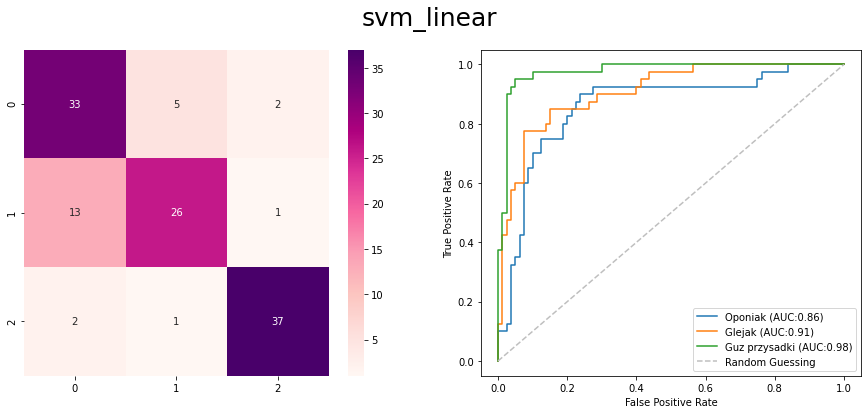

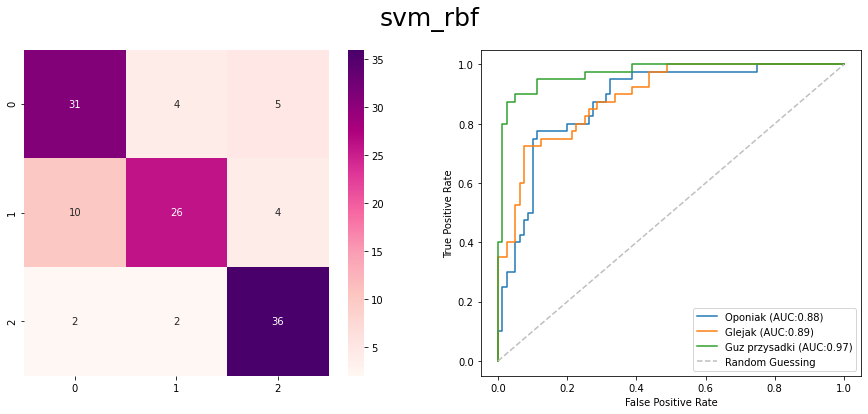

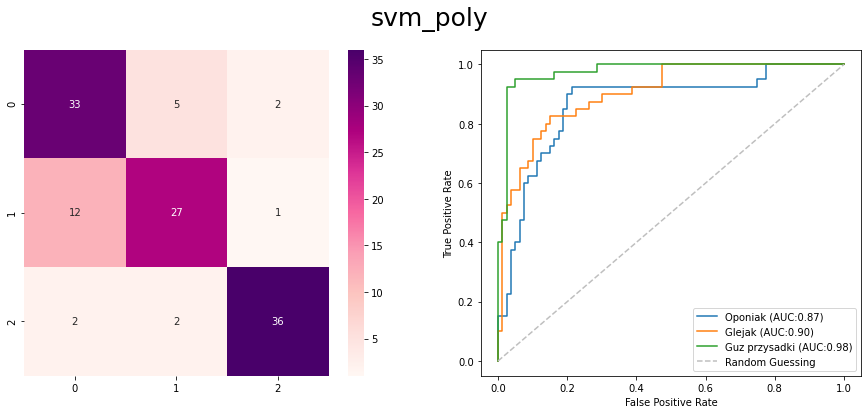

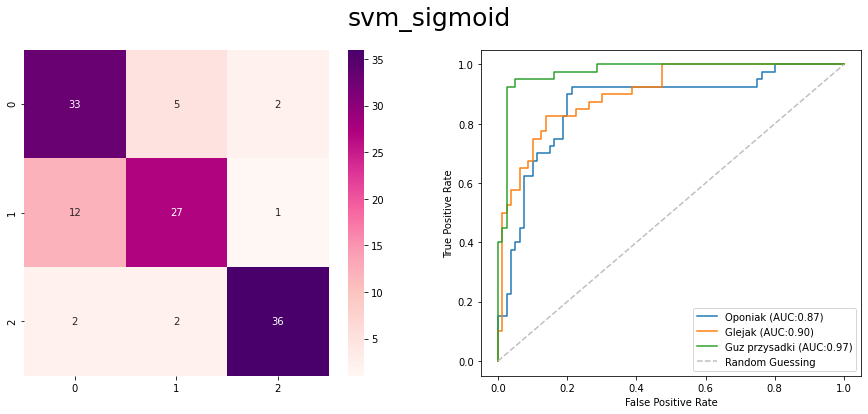

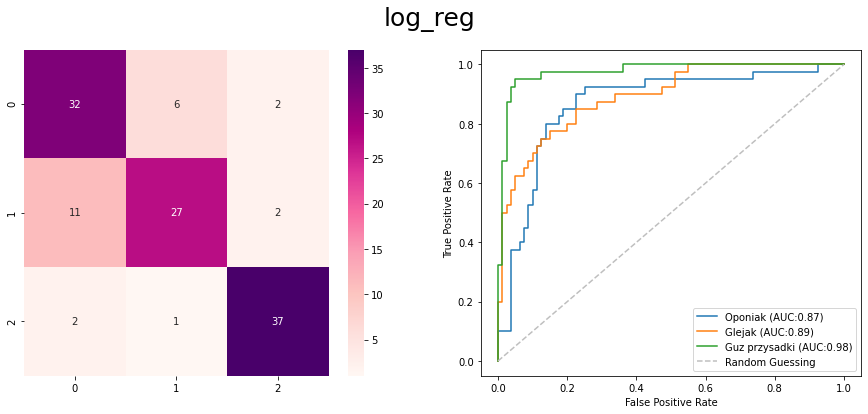

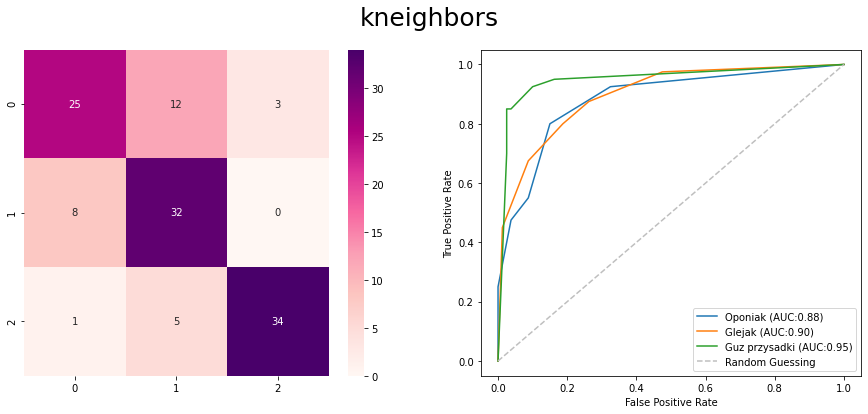

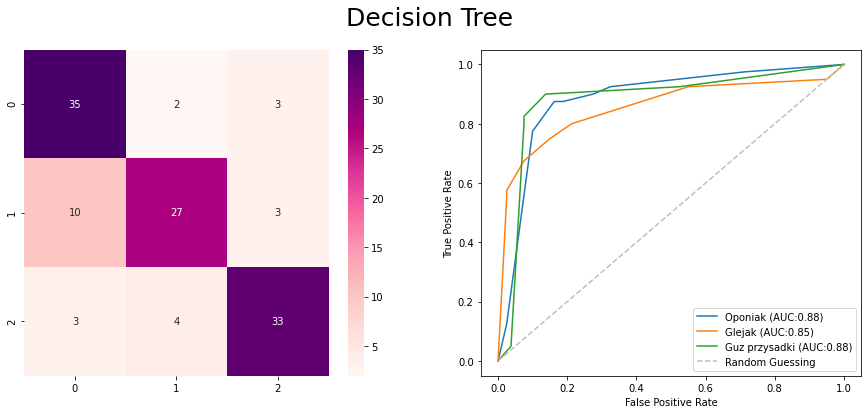

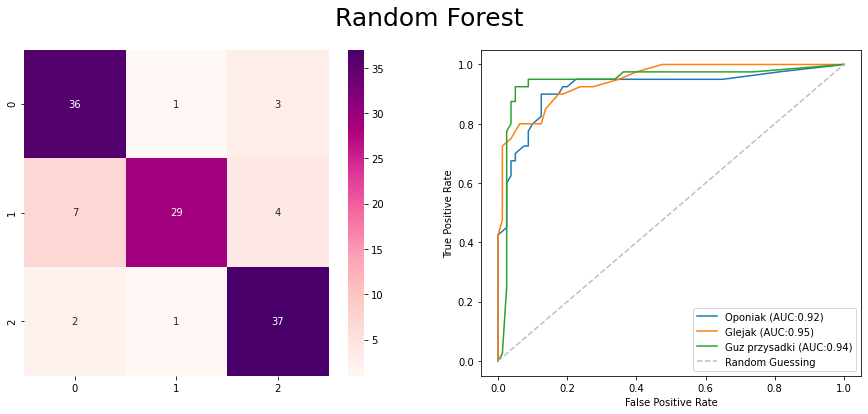

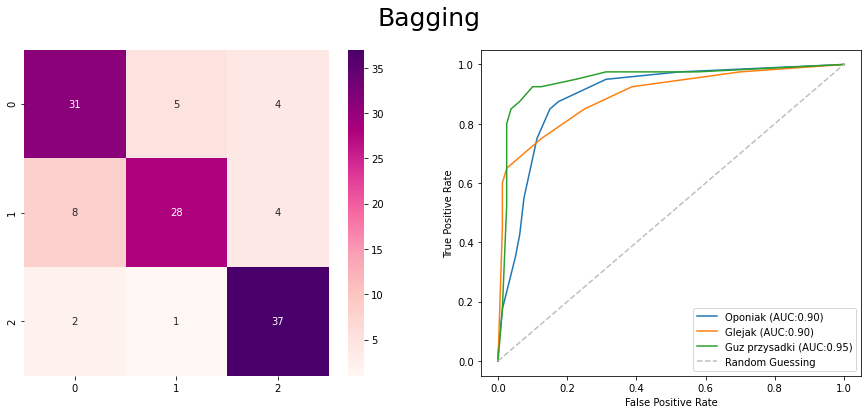

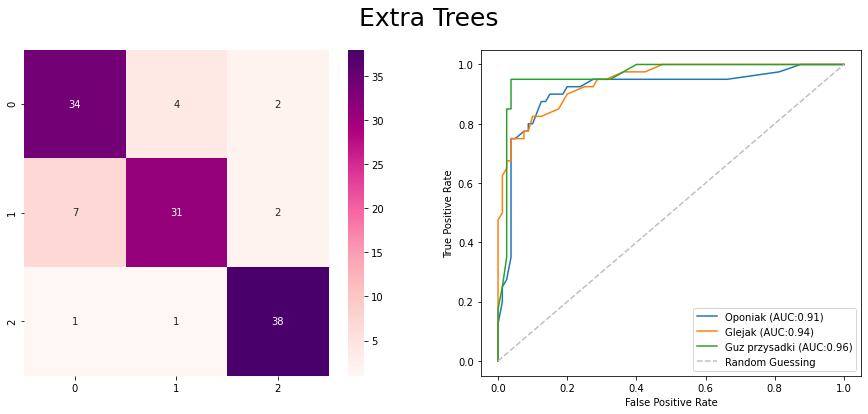

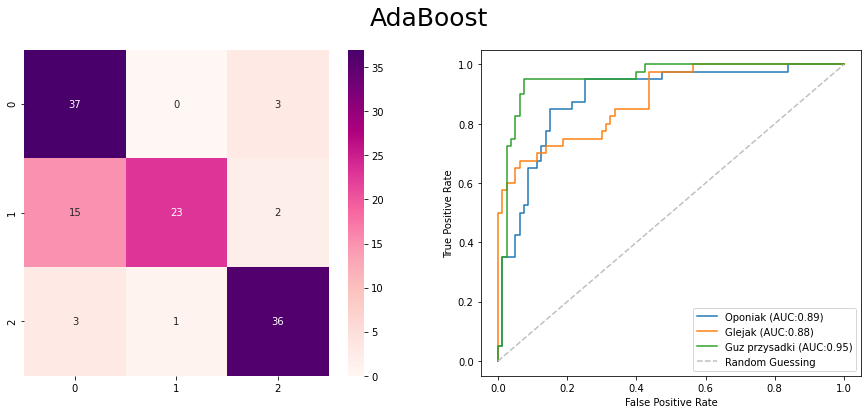

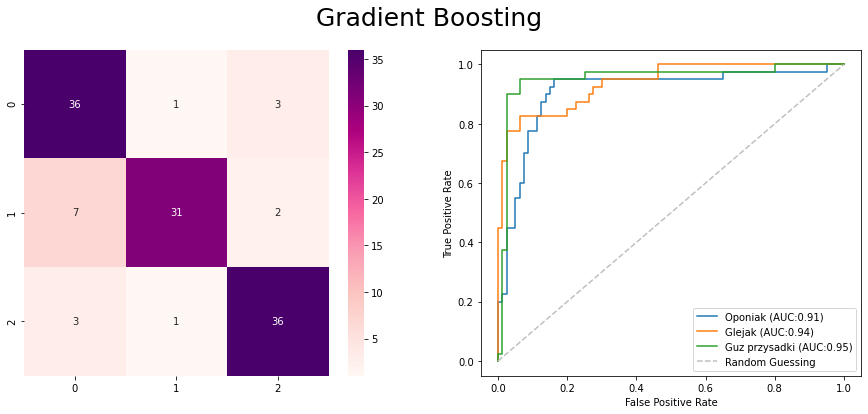

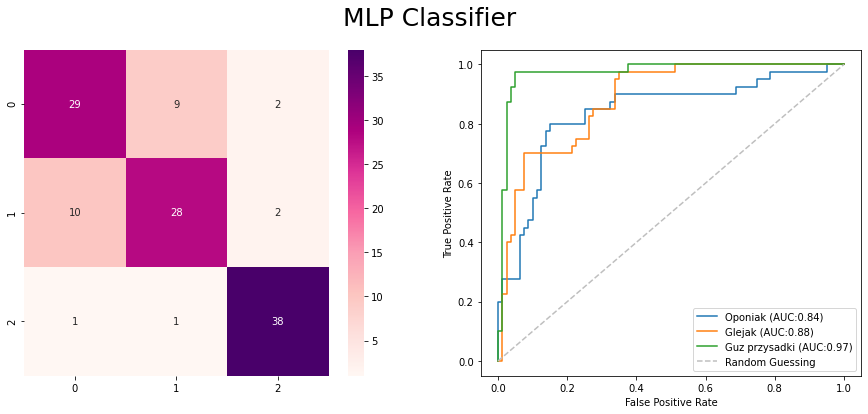

In [54]:
for name in models:
    print(f'======================== {name} ========================')
    model = models[name]
    true_classes = y_test
    predicted_probas, predicted_classes = predictions[name]

    report = metrics.classification_report(true_classes, predicted_classes)

    print(report)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
    fig.suptitle(name, fontsize=25)
    plot_confusion_matrix(predicted_classes, true_classes, ax1)
    plot_roc_curve(true_classes, predicted_probas, ax2)
    

## Podsumowanie

In [55]:
def print_proba(score, i):
    print(
    f"{cancer_type[i]} : {score[i] * 100:0.2f}%"
)

In [56]:
img = keras.preprocessing.image.load_img(
    "data/val/3/15.jpg", target_size=image_size
)
# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)
print(img_array.shape)

# p = model.predict_proba(img_array)
# score = p[0]
# print(score)
# print_proba(score, 0)
# print_proba(score, 1)
# print_proba(score, 2)

NameError: name 'img_array' is not defined